In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn-white')

## Data Wrangling

In [3]:
buys_raw=pd.read_csv('yoochoose-buys.csv',names=['sessionID','ts','itemID','price','cnt'])
print("buys train shape",buys_raw.shape)
buys_raw['status']=1


clicks_raw=pd.read_csv('yoochoose-clicks.csv',names=['sessionID','ts','itemID','cat'])
print("clicks_raw train shape",clicks_raw.shape)
clicks_raw['status']=0

union=pd.concat([clicks_raw, buys_raw], ignore_index=True).sort_values(by=['sessionID','itemID'])
print("union shape",union.shape)
union.head()

buys train shape (1150753, 5)


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


clicks_raw train shape (33003944, 4)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


union shape (34154697, 7)


,cat,cnt,itemID,price,sessionID,status,ts
1,0,NaN,214536500,NaN,1,0,2014-04-07T10:54:09.868Z
0,0,NaN,214536502,NaN,1,0,2014-04-07T10:51:09.277Z
2,0,NaN,214536506,NaN,1,0,2014-04-07T10:54:46.998Z
3,0,NaN,214577561,NaN,1,0,2014-04-07T10:57:00.306Z
9,0,NaN,214551617,NaN,2,0,2014-04-07T14:02:36.889Z


In [4]:
#datetime manipulation
union['ts']=pd.to_datetime(union.ts,infer_datetime_format=True)

In [5]:
union.head(12345).groupby(["itemID","sessionID"])["status"].nunique().max()

2

In [6]:
#NaN
union['cat']=union['cat'].fillna(method='ffill')


union['hour']=union.ts.dt.hour
union['weekday']=union['ts'].dt.dayofweek.astype(int)+1

In [7]:
union.head()

,cat,cnt,itemID,price,sessionID,status,ts,hour,weekday
1,0,NaN,214536500,NaN,1,0,2014-04-07 10:54:09.868000+00:00,10,1
0,0,NaN,214536502,NaN,1,0,2014-04-07 10:51:09.277000+00:00,10,1
2,0,NaN,214536506,NaN,1,0,2014-04-07 10:54:46.998000+00:00,10,1
3,0,NaN,214577561,NaN,1,0,2014-04-07 10:57:00.306000+00:00,10,1
9,0,NaN,214551617,NaN,2,0,2014-04-07 14:02:36.889000+00:00,14,1


## EDA

## Overview

In [8]:
buyID_num=buys_raw.sessionID.nunique() #
buyEvents=buys_raw.shape[0]
clickID_num=clicks_raw.sessionID.nunique()
itemClicks=clicks_raw.shape[0]
BC_ratio=buyID_num/clickID_num

In [9]:
print(r'''buyID_num:{} 
buyEvents:{} 
clickID_num:{} 
itemClicks:{} 
buy ratio of sessions :{}
buy ratio of clicks:{}'''
.format(buyID_num,buyEvents,clickID_num,itemClicks,BC_ratio,buyEvents/clickID_num))

buyID_num:509696 
buyEvents:1150753 
clickID_num:9249729 
itemClicks:33003944 
buy ratio of sessions :0.05510388466516154
buy ratio of clicks:0.1244093745881636


In [10]:
buyEvents/clickID_num

0.1244093745881636

# Statistics


## Buy Ratio Averaged for Time

In [11]:
# Buy ratio averaged for hour
hour_info=union.groupby(['hour','status'])['sessionID'].nunique().reset_index(name='count')
hour_click=hour_info[hour_info['status']==0]
hour_buy=hour_info[hour_info['status']==1]
hour_info=pd.merge(hour_click,hour_buy,on='hour')
hour_info['ratio']=hour_info['count_y']/hour_info['count_x']

In [12]:
# Buy ratio averaged for weekday
weekday_info=union.groupby(['weekday','status'])['sessionID'].nunique().reset_index(name='count')
weekday_click=weekday_info[weekday_info['status']==0]
weekday_buy=weekday_info[weekday_info['status']==1]
weekday_info=pd.merge(weekday_click,weekday_buy,on='weekday')
weekday_info['ratio']=weekday_info.count_y/weekday_info.count_x

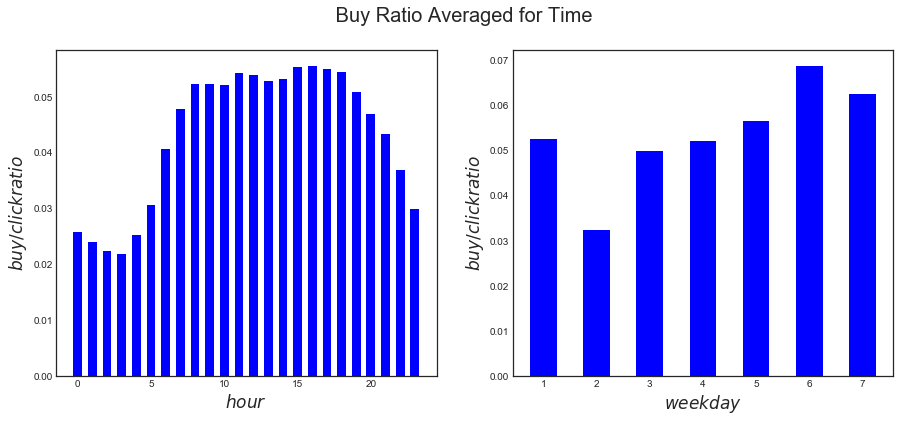

In [13]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Time', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(hour_info['hour'],hour_info['ratio'],width=0.6,color='b')


ax1.set_xlabel('$hour$', fontsize=17)
ax1.set_ylabel('$buy/click ratio$', fontsize=17)
ax2.bar(weekday_info['weekday'],weekday_info['ratio'],width=0.5,color='b')
ax2.set_xlabel('$weekday$', fontsize=17)
ax2.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

In [14]:
## buy ratio goes up at end of week and on weekend expecially on saturdays (tie this to pinterest)
## buy ratio highest in afternoon to evening before 7pm

## Buy Ratio Averaged for Category

In [15]:
def cat_classfier(value):
    if value=='S':
        return '13'
    elif len(value)<=2:
        return value
    else:
        return '14'

In [16]:
union['cat']=union.cat.astype(str).apply(cat_classfier).astype(int)
cat_info=union.groupby(['cat','status'])['sessionID'].nunique().reset_index(name='count').sort_values(by='cat')
cat_click=cat_info[cat_info['status']==0]
cat_buy=cat_info[cat_info['status']==1]
cat_info=pd.merge(cat_click,cat_buy,on='cat')
cat_info['ratio']=cat_info.count_y/cat_info.count_x

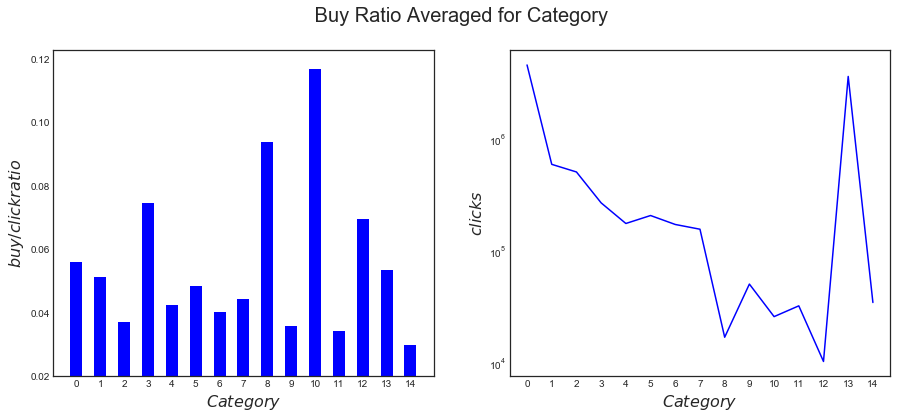

<Figure size 576x288 with 0 Axes>

In [17]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Category', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))

ax1.bar(cat_info.cat,cat_info.ratio,width=0.5,color='b')
ax1.set_xticks(range(0,15))
ax1.set_ylim(0.02)
ax1.set_ylabel('$buy/click ratio$',fontsize=16)
ax1.set_xlabel('$Category$',fontsize=16)

ax2.plot(cat_info.count_x,color='b')
ax2.set_yscale('log')
ax2.set_ylabel('$clicks$',fontsize=16)
ax2.set_xticks(range(0,15))
ax2.set_xlabel('$Category$',fontsize=16)

plt.show()

In [ ]:
## 13 = special offer, 14 = brand, 0 = uncategorized, 1-12 = category like sports etc

## buy ratio highest for category 3, 8, 12 -- however they do not receive many clicks
## most clicks received by special offer -- which does not have a high buy ratio 

# Initial Code

## Transforming clicks data 
#### **data will be read from csv in chunks of 500,000 to make processing faster

### 1. converting item categories 


In [33]:
def clean_cat (category):
    if category == 'S':
        return -1
    elif category in ['1','2','3','4','5','6','7','8','9','10','11','12']:
        return category
    else:
        return 13

In [35]:
df_cat=None
count = 1

for chunk in pd.read_csv('yoochoose-clicks.csv', \
                         converters={"category": clean_cat},\
                         names=["session", "timestamp", "item_id", "category"],parse_dates=["timestamp"],\
                         chunksize=500000):
    
    print("Executing # ",count," of 67")
    clicks_data = chunk
    
    if df is None:
        df_cat=clicks_data
        count=count+1
    else:
        df_cat = df_cat.append(clicks_data)  
        count=count+1
        


Executing #  1  of 67
Executing #  2  of 67
Executing #  3  of 67
Executing #  4  of 67
Executing #  5  of 67
Executing #  6  of 67
Executing #  7  of 67
Executing #  8  of 67
Executing #  9  of 67
Executing #  10  of 67
Executing #  11  of 67
Executing #  12  of 67
Executing #  13  of 67
Executing #  14  of 67
Executing #  15  of 67
Executing #  16  of 67
Executing #  17  of 67
Executing #  18  of 67
Executing #  19  of 67
Executing #  20  of 67
Executing #  21  of 67
Executing #  22  of 67
Executing #  23  of 67
Executing #  24  of 67
Executing #  25  of 67
Executing #  26  of 67
Executing #  27  of 67
Executing #  28  of 67
Executing #  29  of 67


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Executing #  30  of 67
Executing #  31  of 67
Executing #  32  of 67
Executing #  33  of 67
Executing #  34  of 67
Executing #  35  of 67
Executing #  36  of 67
Executing #  37  of 67
Executing #  38  of 67
Executing #  39  of 67
Executing #  40  of 67
Executing #  41  of 67
Executing #  42  of 67
Executing #  43  of 67
Executing #  44  of 67
Executing #  45  of 67
Executing #  46  of 67
Executing #  47  of 67
Executing #  48  of 67
Executing #  49  of 67
Executing #  50  of 67
Executing #  51  of 67
Executing #  52  of 67
Executing #  53  of 67
Executing #  54  of 67
Executing #  55  of 67
Executing #  56  of 67
Executing #  57  of 67
Executing #  58  of 67
Executing #  59  of 67
Executing #  60  of 67
Executing #  61  of 67
Executing #  62  of 67
Executing #  63  of 67
Executing #  64  of 67
Executing #  65  of 67
Executing #  66  of 67
Executing #  67  of 67


### 2. calculate aggregate features for clicks data 
   dwell time, total clicks per item, day of week and month, hour of click, time of day of click, and click rate

In [47]:
def calc_aggregates (x):
        
        clicks_1 = x.groupby('session')['timestamp'].agg([min,max])
        
        
        #calc dwell time of each session in seconds
        clicks_1['dwell_time'] = clicks_1['max'] - clicks_1['min'] 
        clicks_1['dwell_time'] = clicks_1['dwell_time'].dt.total_seconds() 

        grouped_clicks = x.groupby('session')
            
        #calc total clicks er item
        clicks_1['total_clicks'] = grouped_clicks.item_id.count()
        
        #calc day of week
        clicks_1['dayofweek'] = clicks_1['min'].dt.dayofweek
        
        #calc day of month
        clicks_1['dayofmonth'] = clicks_1['min'].dt.day
        
        #calc hour of click
        clicks_1['click_hour'] = clicks_1['min'].dt.hour
        
        #calc time of day of click
        bins = [0,4,8,12,16,20,24]
        t = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
        clicks_1['timeofday'] = pd.cut(clicks_1['click_hour'], bins=bins, labels=t, include_lowest=True)
        
        #calc CTR -- click rate
        clicks_1["CTR"] = clicks_1["total_clicks"] / clicks_1["dwell_time"]
        clicks_1.CTR = clicks_1.CTR.replace(np.inf, np.nan)
        clicks_1.CTR = clicks_1.CTR.fillna(0)
        
        
        return clicks_1

In [48]:
df=None
count = 1

for chunk in pd.read_csv('yoochoose-clicks.csv', \
                         converters={"category": clean_cat},\
                         names=["session", "timestamp", "item_id", "category"],parse_dates=["timestamp"],\
                         chunksize=500000):
    
    print("Executing # ",count," of 67")
    clicks_data = calc_aggregates(chunk)
    
    if df is None:
        df=clicks_data
        count=count+1
    else:
        df = df.append(clicks_data)  
        count=count+1

Executing #  1  of 67


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Executing #  2  of 67
Executing #  3  of 67
Executing #  4  of 67
Executing #  5  of 67
Executing #  6  of 67
Executing #  7  of 67
Executing #  8  of 67
Executing #  9  of 67
Executing #  10  of 67
Executing #  11  of 67
Executing #  12  of 67
Executing #  13  of 67
Executing #  14  of 67
Executing #  15  of 67
Executing #  16  of 67
Executing #  17  of 67
Executing #  18  of 67
Executing #  19  of 67
Executing #  20  of 67
Executing #  21  of 67
Executing #  22  of 67
Executing #  23  of 67
Executing #  24  of 67
Executing #  25  of 67
Executing #  26  of 67
Executing #  27  of 67
Executing #  28  of 67
Executing #  29  of 67


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Executing #  30  of 67
Executing #  31  of 67
Executing #  32  of 67
Executing #  33  of 67
Executing #  34  of 67
Executing #  35  of 67
Executing #  36  of 67
Executing #  37  of 67
Executing #  38  of 67
Executing #  39  of 67
Executing #  40  of 67
Executing #  41  of 67
Executing #  42  of 67
Executing #  43  of 67
Executing #  44  of 67
Executing #  45  of 67
Executing #  46  of 67
Executing #  47  of 67
Executing #  48  of 67
Executing #  49  of 67
Executing #  50  of 67
Executing #  51  of 67
Executing #  52  of 67
Executing #  53  of 67
Executing #  54  of 67
Executing #  55  of 67
Executing #  56  of 67
Executing #  57  of 67
Executing #  58  of 67
Executing #  59  of 67
Executing #  60  of 67
Executing #  61  of 67
Executing #  62  of 67
Executing #  63  of 67
Executing #  64  of 67
Executing #  65  of 67
Executing #  66  of 67
Executing #  67  of 67


In [60]:
df.head()

,CTR,category,click_hour,dayofmonth,dayofweek,dwell_time,item_id,max,min,session,timeofday,timestamp,total_clicks
0,NaN,13,NaN,NaN,NaN,NaN,214536502.0,NaT,NaT,1.0,NaN,2014-04-07 10:51:09.277000+00:00,NaN
1,NaN,13,NaN,NaN,NaN,NaN,214536500.0,NaT,NaT,1.0,NaN,2014-04-07 10:54:09.868000+00:00,NaN
2,NaN,13,NaN,NaN,NaN,NaN,214536506.0,NaT,NaT,1.0,NaN,2014-04-07 10:54:46.998000+00:00,NaN
3,NaN,13,NaN,NaN,NaN,NaN,214577561.0,NaT,NaT,1.0,NaN,2014-04-07 10:57:00.306000+00:00,NaN
4,NaN,13,NaN,NaN,NaN,NaN,214662742.0,NaT,NaT,2.0,NaN,2014-04-07 13:56:37.614000+00:00,NaN


### 3. Calculate first and last item, total unique items and unique categories clicked on during each session

In [61]:
def item_cat(x):
    df = x.groupby('session').agg({'item_id':['first','last','nunique'],'category':['nunique']})        
    return df

In [63]:
df2=None
count = 1

for chunk in pd.read_csv('yoochoose-clicks.csv', \
                         converters={"category": clean_cat},\
                         usecols = ['session','item_id', 'category'],\
                         names=["session", "timestamp", "item_id", "category"],\
                         chunksize=500000):
    
    print("Executing # ",count," of 67")
    clicks_data = item_cat(chunk)
    
    if df2 is None:
        df2=clicks_data
        count=count+1
    else:
        df2 = df2.append(clicks_data)  
        count=count+1

Executing #  1  of 67
Executing #  2  of 67
Executing #  3  of 67
Executing #  4  of 67
Executing #  5  of 67
Executing #  6  of 67
Executing #  7  of 67
Executing #  8  of 67
Executing #  9  of 67
Executing #  10  of 67
Executing #  11  of 67
Executing #  12  of 67
Executing #  13  of 67
Executing #  14  of 67
Executing #  15  of 67
Executing #  16  of 67
Executing #  17  of 67
Executing #  18  of 67
Executing #  19  of 67
Executing #  20  of 67
Executing #  21  of 67
Executing #  22  of 67
Executing #  23  of 67
Executing #  24  of 67
Executing #  25  of 67
Executing #  26  of 67
Executing #  27  of 67
Executing #  28  of 67
Executing #  29  of 67


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Executing #  30  of 67
Executing #  31  of 67
Executing #  32  of 67
Executing #  33  of 67
Executing #  34  of 67
Executing #  35  of 67
Executing #  36  of 67
Executing #  37  of 67
Executing #  38  of 67
Executing #  39  of 67
Executing #  40  of 67
Executing #  41  of 67
Executing #  42  of 67
Executing #  43  of 67
Executing #  44  of 67
Executing #  45  of 67
Executing #  46  of 67
Executing #  47  of 67
Executing #  48  of 67
Executing #  49  of 67
Executing #  50  of 67
Executing #  51  of 67
Executing #  52  of 67
Executing #  53  of 67
Executing #  54  of 67
Executing #  55  of 67
Executing #  56  of 67
Executing #  57  of 67
Executing #  58  of 67
Executing #  59  of 67
Executing #  60  of 67
Executing #  61  of 67
Executing #  62  of 67
Executing #  63  of 67
Executing #  64  of 67
Executing #  65  of 67
Executing #  66  of 67
Executing #  67  of 67


In [64]:
df2.head()

item_id                    category
             first       last nunique  nunique
session                                       
1        214536502  214577561       4        1
2        214662742  214551617       5        1
3        214716935  214832672       3        1
4        214836765  214706482       2        1
6        214701242  214826623       2        1

In [65]:
cols=['first_clicked_item','last_clicked_item','total_unique_items','total_unique_categories']
df2.columns = cols

In [70]:
df2.head()

,first_clicked_item,last_clicked_item,total_unique_items,total_unique_categories
session,,,,
1,214536502,214577561,4,1
2,214662742,214551617,5,1
3,214716935,214832672,3,1
4,214836765,214706482,2,1
6,214701242,214826623,2,1


### 4. Get all items (including duplicates) clicked on during each session

In [71]:
def item_per_session(x):
       
        #getting key-value pairs by transpoing sessions data -- key is session id and value is item id
        #result is a list of lists of items in each session
        keys, values = x.sort_values('session').values.T
        unique_keys, index = np.unique(keys, True)
        arrays = np.split(values, index[1:])
        df = pd.DataFrame({'a':unique_keys, 'b':arrays})
        return df

In [73]:
df3=None
count = 1

for chunk in pd.read_csv('yoochoose-clicks.csv', \
                         #converters={"category": clean_cat},\
                         usecols = ['session','item_id'],\
                         names=["session", "timestamp", "item_id", "category"],\
                         chunksize=500000):
    
    print("Executing # ",count," of 67")
    clicks_data = item_per_session(chunk)
    
    if df3 is None:
        df3=clicks_data
        count=count+1
    else:
        df3 = df3.append(clicks_data)  
        count=count+1

Executing #  1  of 67
Executing #  2  of 67
Executing #  3  of 67
Executing #  4  of 67
Executing #  5  of 67
Executing #  6  of 67
Executing #  7  of 67
Executing #  8  of 67
Executing #  9  of 67
Executing #  10  of 67
Executing #  11  of 67
Executing #  12  of 67
Executing #  13  of 67
Executing #  14  of 67
Executing #  15  of 67
Executing #  16  of 67
Executing #  17  of 67
Executing #  18  of 67
Executing #  19  of 67
Executing #  20  of 67
Executing #  21  of 67
Executing #  22  of 67
Executing #  23  of 67
Executing #  24  of 67
Executing #  25  of 67
Executing #  26  of 67
Executing #  27  of 67
Executing #  28  of 67
Executing #  29  of 67
Executing #  30  of 67
Executing #  31  of 67
Executing #  32  of 67
Executing #  33  of 67
Executing #  34  of 67
Executing #  35  of 67
Executing #  36  of 67
Executing #  37  of 67
Executing #  38  of 67
Executing #  39  of 67
Executing #  40  of 67
Executing #  41  of 67
Executing #  42  of 67
Executing #  43  of 67
Executing #  44  of 

In [74]:
df3.head()

,a,b
0,1,"[214536502, 214536500, 214536506, 214577561]"
1,2,"[214662742, 214662742, 214825110, 214757390, 2..."
2,3,"[214716935, 214774687, 214832672]"
3,4,"[214706482, 214836765]"
4,6,"[214701242, 214826623]"


In [75]:
cols=['session','items_clicked']
df3.columns = cols

In [76]:
df3.head()

,session,items_clicked
0,1,"[214536502, 214536500, 214536506, 214577561]"
1,2,"[214662742, 214662742, 214825110, 214757390, 2..."
2,3,"[214716935, 214774687, 214832672]"
3,4,"[214706482, 214836765]"
4,6,"[214701242, 214826623]"


### 5. Get all categories clicked on during each session

In [77]:
def cat_per_session(x):
       
        #getting key-value pairs by transpoing sessions data -- key is session id and value is category
        #result is a list of lists of categories in each session
        keys, values = x.sort_values('session').values.T
        unique_keys, index = np.unique(keys, True)
        arrays = np.split(values, index[1:])
        df = pd.DataFrame({'a':unique_keys, 'b':arrays})
        return df

In [78]:
df4=None
count = 1

for chunk in pd.read_csv('yoochoose-clicks.csv', \
                         #converters={"category": clean_cat},\
                         usecols = ['session','item_id'],\
                         names=["session", "timestamp", "item_id", "category"],\
                         chunksize=500000):
    
    print("Executing # ",count," of 67")
    clicks_data = item_per_session(chunk)
    
    if df4 is None:
        df4=clicks_data
        count=count+1
    else:
        df4 = df4.append(clicks_data)  
        count=count+1

Executing #  1  of 67
Executing #  2  of 67
Executing #  3  of 67
Executing #  4  of 67
Executing #  5  of 67
Executing #  6  of 67
Executing #  7  of 67
Executing #  8  of 67
Executing #  9  of 67
Executing #  10  of 67
Executing #  11  of 67
Executing #  12  of 67
Executing #  13  of 67
Executing #  14  of 67
Executing #  15  of 67
Executing #  16  of 67
Executing #  17  of 67
Executing #  18  of 67
Executing #  19  of 67
Executing #  20  of 67
Executing #  21  of 67
Executing #  22  of 67
Executing #  23  of 67
Executing #  24  of 67
Executing #  25  of 67
Executing #  26  of 67
Executing #  27  of 67
Executing #  28  of 67
Executing #  29  of 67
Executing #  30  of 67
Executing #  31  of 67
Executing #  32  of 67
Executing #  33  of 67
Executing #  34  of 67
Executing #  35  of 67
Executing #  36  of 67
Executing #  37  of 67
Executing #  38  of 67
Executing #  39  of 67
Executing #  40  of 67
Executing #  41  of 67
Executing #  42  of 67
Executing #  43  of 67
Executing #  44  of 

In [79]:
df4.head()

,a,b
0,1,"[214536502, 214536500, 214536506, 214577561]"
1,2,"[214662742, 214662742, 214825110, 214757390, 2..."
2,3,"[214716935, 214774687, 214832672]"
3,4,"[214706482, 214836765]"
4,6,"[214701242, 214826623]"


In [84]:
cols=['session','category_clicked']
df4.columns = cols

In [85]:
df4.head()

,session,category_clicked
0,1,"[214536502, 214536500, 214536506, 214577561]"
1,2,"[214662742, 214662742, 214825110, 214757390, 2..."
2,3,"[214716935, 214774687, 214832672]"
3,4,"[214706482, 214836765]"
4,6,"[214701242, 214826623]"


### calculate total categories clicked 
### identify sessions with a special offer click

In [86]:
df4['total_categories_clicked'] = df4['category_clicked'].apply(lambda x : len(x))

In [87]:
df4.head()

,session,category_clicked,total_categories_clicked
0,1,"[214536502, 214536500, 214536506, 214577561]",4
1,2,"[214662742, 214662742, 214825110, 214757390, 2...",6
2,3,"[214716935, 214774687, 214832672]",3
3,4,"[214706482, 214836765]",2
4,6,"[214701242, 214826623]",2


In [88]:
def special(x):
        if -1 in x:
            return 1
        else:
            return 0

In [89]:
df4['Special_offer_click']=df4['category_clicked'].apply(special)

In [90]:
df4.head()

,session,category_clicked,total_categories_clicked,Special_offer_click
0,1,"[214536502, 214536500, 214536506, 214577561]",4,0
1,2,"[214662742, 214662742, 214825110, 214757390, 2...",6,0
2,3,"[214716935, 214774687, 214832672]",3,0
3,4,"[214706482, 214836765]",2,0
4,6,"[214701242, 214826623]",2,0


## Final clicks data:

In [92]:
clicks_tranformed = pd.concat([df, df2, df3, df4])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [93]:
clicks_tranformed.head()

,CTR,Special_offer_click,category,category_clicked,click_hour,dayofmonth,dayofweek,dwell_time,first_clicked_item,item_id,...,last_clicked_item,max,min,session,timeofday,timestamp,total_categories_clicked,total_clicks,total_unique_categories,total_unique_items
0,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,214536502.0,...,NaN,NaT,NaT,1.0,NaN,2014-04-07 10:51:09.277000+00:00,NaN,NaN,NaN,NaN
1,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,214536500.0,...,NaN,NaT,NaT,1.0,NaN,2014-04-07 10:54:09.868000+00:00,NaN,NaN,NaN,NaN
2,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,214536506.0,...,NaN,NaT,NaT,1.0,NaN,2014-04-07 10:54:46.998000+00:00,NaN,NaN,NaN,NaN
3,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,214577561.0,...,NaN,NaT,NaT,1.0,NaN,2014-04-07 10:57:00.306000+00:00,NaN,NaN,NaN,NaN
4,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,214662742.0,...,NaN,NaT,NaT,2.0,NaN,2014-04-07 13:56:37.614000+00:00,NaN,NaN,NaN,NaN


## Transforming buys data

In [94]:
buys_raw.head()

,sessionID,ts,itemID,price,cnt,status
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1,1


In [97]:
cols=["session","timestamp","item_id","price","qty", "status"]
buys_raw.columns = cols

In [98]:
buys_raw.drop('status', axis=1, inplace=True)  

In [99]:
grouped_buys = buys_raw.groupby("session")

In [102]:
grouped_buys.head()

,session,timestamp,item_id,price,qty
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1
5,140806,2014-04-07T09:22:28.132Z,214668193,523,1
6,140806,2014-04-07T09:22:28.176Z,214587399,1046,1
7,140806,2014-04-07T09:22:28.219Z,214586690,837,1
8,140806,2014-04-07T09:22:28.268Z,214774667,1151,1
9,140806,2014-04-07T09:22:28.280Z,214578823,1046,1


In [104]:
buys = pd.DataFrame(index=grouped_buys.groups.keys())        

In [105]:
buys["count_items_bought"] = grouped_buys.item_id.count()

In [107]:
buys["unique_items_bought"] = grouped_buys.item_id.nunique()

In [108]:
buys["is_buy"] = 1
buys.index.name = "session"

In [109]:
buys.head()

,count_items_bought,unique_items_bought,is_buy
session,,,
11,2,1,1
12,1,1,1
21,2,2,1
33,6,3,1
46,2,1,1


## Final DF with clicks and buys data

In [110]:
training = pd.merge(clicks_tranformed,buys['is_buy'],how='left',left_index=True,right_index=True)
training['is_buy'] = training['is_buy'].fillna(0)

### get total #  of buy vs non buying events

In [112]:
print(training['is_buy'].value_counts())

0.0    67501876
1.0     2501164
Name: is_buy, dtype: int64


### undersampling -- to handle class imbalance

In [114]:
def undersampling(x):   
        
        count_class_0, count_class_1 = x['is_buy'].value_counts()
        df_0 = x[x['is_buy'] == 0]
        df_1 = x[x['is_buy'] == 1]
        df_0_under = df_0.sample(count_class_1)
        df_test_under = pd.concat([df_0_under, df_1], axis=0)
        df_test_under['is_buy'].value_counts()
        return df_test_under

In [115]:
balanced_data = undersampling(training)
print(balanced_data['is_buy'].value_counts())

1.0    2501164
0.0    2501164
Name: is_buy, dtype: int64


# Logistic Regression -- buy vs not buy prediction

#### one hot encode timeofday column 

In [120]:
def one_hot_encode (column_name,training_data):
    temp = pd.get_dummies(training_data[column_name])
    training_data = pd.concat([training_data, temp], axis=1)
    return training_data

In [121]:
training = one_hot_encode("timeofday",balanced_data)

In [123]:
training.columns

Index(['CTR', 'Special_offer_click', 'category', 'category_clicked',
       'click_hour', 'dayofmonth', 'dayofweek', 'dwell_time',
       'first_clicked_item', 'item_id', 'items_clicked', 'last_clicked_item',
       'max', 'min', 'session', 'timeofday', 'timestamp',
       'total_categories_clicked', 'total_clicks', 'total_unique_categories',
       'total_unique_items', 'is_buy', 'Afternoon', 'Early Morning', 'Evening',
       'Late Night', 'Morning', 'Night'],
      dtype='object')

In [124]:
preprocessed_training = training.loc[:,~training.columns.isin([
    'min', 'max', 'dwell_time',
       'first_clicked_item', 'last_clicked_item','timeofday',
       'items_clicked', 'category_clicked','click_hour', 'total_unique_items', 'count_x',
       'count_y'
])]

In [125]:
preprocessed_training.head()

,CTR,Special_offer_click,category,dayofmonth,dayofweek,item_id,session,timestamp,total_categories_clicked,total_clicks,total_unique_categories,is_buy,Afternoon,Early Morning,Evening,Late Night,Morning,Night
1446300,NaN,NaN,13,NaN,NaN,214820812.0,491451.0,2014-04-05 17:11:11.338000+00:00,NaN,NaN,NaN,0.0,0,0,0,0,0,0
5524852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,1.0,0.0,0,0,0,0,0,0
35111,NaN,NaN,NaN,NaN,NaN,NaN,10852484.0,NaT,NaN,NaN,NaN,0.0,0,0,0,0,0,0
15810905,NaN,NaN,7,NaN,NaN,214844214.0,5506541.0,2014-06-29 19:34:46.427000+00:00,NaN,NaN,NaN,0.0,0,0,0,0,0,0
3794451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,1.0,0.0,0,0,0,0,0,0


### feature correlation heatmap

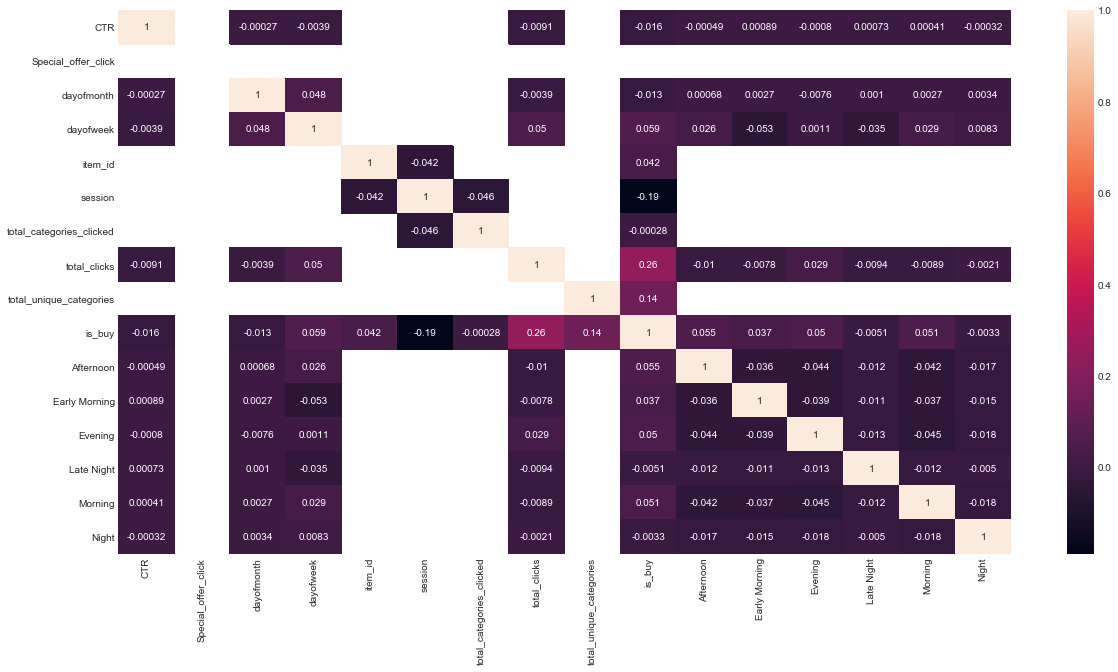

In [127]:
corr_matrix = preprocessed_training.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### split into train and test

In [131]:
from sklearn.model_selection import train_test_split

In [149]:
preprocessed_training.drop('timestamp', axis=1, inplace=True)  


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [160]:
preprocessed_training = preprocessed_training.dropna(how='all')

In [161]:
preprocessed_training.head()

,CTR,Special_offer_click,category,dayofmonth,dayofweek,item_id,session,total_categories_clicked,total_clicks,total_unique_categories,is_buy,Afternoon,Early Morning,Evening,Late Night,Morning,Night
1446300,NaN,NaN,13,NaN,NaN,214820812.0,491451.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0
5524852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0,0,0,0,0,0
35111,NaN,NaN,NaN,NaN,NaN,NaN,10852484.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0
15810905,NaN,NaN,7,NaN,NaN,214844214.0,5506541.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0
3794451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0,0,0,0,0,0


In [162]:
X = preprocessed_training.loc[:,~preprocessed_training.columns.isin(['is_buy'])]
y = preprocessed_training.loc[:,preprocessed_training.columns.isin(['is_buy'])]

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [164]:
y_test['is_buy'] = pd.to_numeric(y_test['is_buy']).round(0).astype(int)
y_train['is_buy'] = pd.to_numeric(y_train['is_buy']).round(0).astype(int)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [165]:
### run regression

In [166]:
def logit(train_x,train_y,test_x,test_y,thres=0.5):
        
        model = LogisticRegression(solver='sag')
        model.fit(train_x,train_y.values.ravel())
        probas = model.predict_proba(test_x)[:, 1]
        y_pred = [1 if probas > thres else 0 for prob in probas]
        return y_pred,probas

In [167]:
pred,prob = logit(X_train,y_train,X_test,y_test,0.49)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## XGBoost

In [137]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [147]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [148]:
xg_reg.fit(X_train,y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.category, timestamp

In [143]:
preds = xg_reg.predict(X_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.category, timestamp

In [141]:
# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))

NameError: name 'preds' is not defined

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()